This notebook can be downloaded from [here](https://gitlab.com/genepy3d/genepy3d.gitlab.io/-/blob/master/source/working_with_curve.ipynb).

# Working with curve

Curve in 3D can be used to handle trajectories in various processes such as 3D particles/fly-fruits tracking or decomposition of neuronal tree. Genepy3D provides module `obj.curves` allowing you to compute useful features from 3D curve. Let's first import it.

In [1]:
from genepy3d.obj import curves

## Creating curve

Using class `Curve` in `obj.curves` to define a curve from a list of coordinates in 3D. Here, we use an example of neuronal tree from which we extract its longest branch starting from its cell body (call as *spine*).

In [2]:
from genepy3d.obj import trees

# reading neuronal tree from swc
filename = "data/FT_T_dG-2.swc"
neuron = trees.Tree.from_swc(filename)

# extracting spine
spine_nodes = neuron.compute_spine() # getting spine nodes
spine_coors = neuron.get_coordinates(spine_nodes).values # getting their coordinates

# creating curve from the spine coordinates
curve = curves.Curve(spine_coors) 

print("number of points on curve:",len(curve.coors))

number of points on curve: 578


`Genepy3D` provides `curve.plot()` to visualize curve:

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
curve.plot(ax);
ax.axis('off');
plt.tight_layout();

<IPython.core.display.Javascript object>

The red dot above indicates the begin point, the curve plot function inherits arguments from `plot()` and `scatter()` functions in `Matplotlib`. You can read their documentation to customize your plot. Some examples of using `curve.plot()` will be also illustrated later. 

Next, we show you how to compute features from curve.

## Basic operations

### Length

In [5]:
print("length of curve:",curve.compute_length())

length of curve: 434.84330582000393


### Resampling

Curve can be resampled using `curve.resample()` function. Spline interpolation is employed in resampling process. The script below resamples the curve based on new spacing distance equals to 0.5 micron with spline degree equals to 2. Note that setting `spline_order = 1` corresponds to linear interpolation. Please this [documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) to get more information on spline interpolation in python.

In [6]:
resampled_curve = curve.resample(unit_length=0.5,spline_order=2)

In [7]:
print("number of points before resampling:",len(curve.coors))
print("number of points after resampling:",len(resampled_curve.coors))

number of points before resampling: 578
number of points after resampling: 870


### Convolution

We provide simple curve convolution with a Gaussian kernel.

In [8]:
sigma = 20 # in micron
conv_curve = resampled_curve.convolve_gaussian(sigma)

<IPython.core.display.Javascript object>


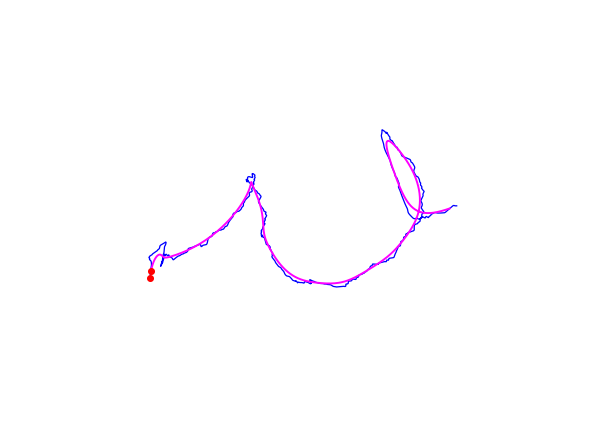

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
resampled_curve.plot(ax);
conv_curve.plot(ax,line_args={"c":"magenta"});
ax.axis('off');
plt.tight_layout();

The parameters in `line_args` of `conv_curve.plot()` above are inherited from `plot()` in `Matplotlib`. Here we set line color as magenta.

### Denoising

We based on this [algorithm](https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/aslDoc/betaSigDoc/betaSigAPI.html) to automaticaly denoise the curve. 

In [10]:
# Create a curve with added noise
import numpy as np
sigma = 2
n_pnt = resampled_curve.size
x = resampled_curve.coors[:,0] + np.random.normal(0,sigma,n_pnt)
y = resampled_curve.coors[:,1] + np.random.normal(0,sigma,n_pnt)
z = resampled_curve.coors[:,2] + np.random.normal(0,sigma,n_pnt)
noisy_curve = curves.Curve((x,y,z))

# Denoise the curve
denoised_curve = noisy_curve.denoise()

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
noisy_curve.plot(ax);
denoised_curve.plot(ax,line_args={"c":"magenta"});
ax.axis('off');
plt.tight_layout();

<IPython.core.display.Javascript object>

### Curvature

The [curvature](https://en.wikipedia.org/wiki/Curvature) of curve can be computed by:

In [12]:
curvature = denoised_curve.compute_curvature()

<IPython.core.display.Javascript object>


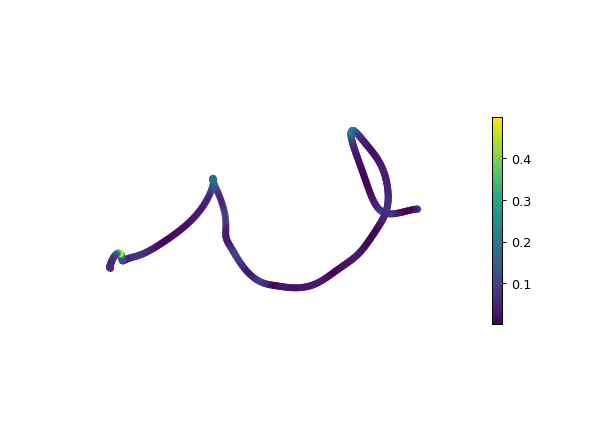

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
_, point_pl, _ = denoised_curve.plot(ax,point_args={"c":curvature})
fig.colorbar(point_pl,shrink=0.5);
ax.axis('off');
plt.tight_layout();

We provide `point_args` argument in curve plot function to visualize points on curve. The parameters in `point_args` are similar to `scatter()` in `Matplotlib`. Here we set `"c":curvature` to map computed curvature of every point to a color map. Moreover, the returns of `denoised_curve.plot()` contains point plot object (`point_pl`) that you can activate the colorbar on it using `fig.colorbar()`.

<IPython.core.display.Javascript object>


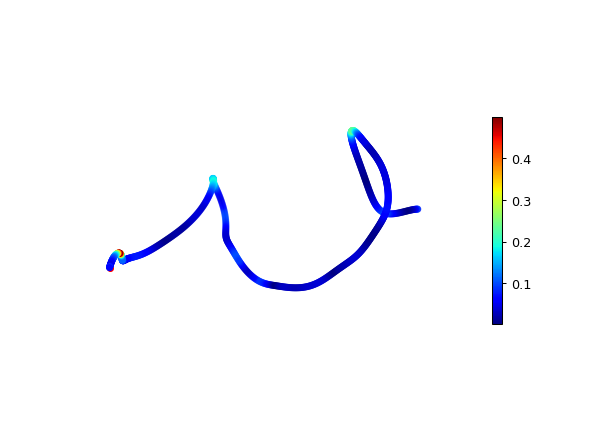

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
_, point_pl, _ = denoised_curve.plot(ax,point_args={"c":curvature,"cmap":"jet"})
fig.colorbar(point_pl,shrink=0.5);
ax.axis('off');
plt.tight_layout();

### Torsion

The [torsion](https://en.wikipedia.org/wiki/Torsion_of_a_curve) of curve can be computed by:

In [15]:
torsion = denoised_curve.compute_torsion()

<IPython.core.display.Javascript object>


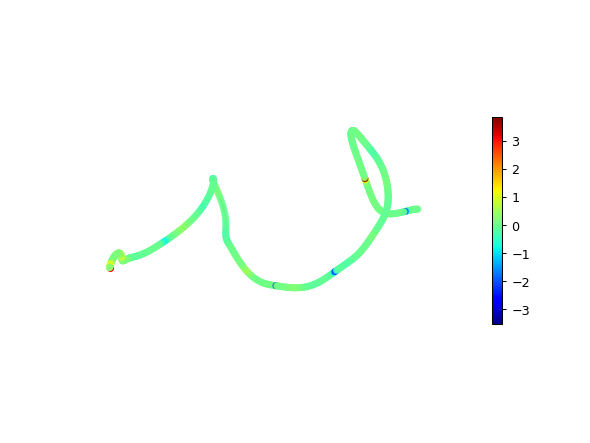

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
_, point_pl, _ = denoised_curve.plot(ax,point_args={"c":torsion,"cmap":"jet"})
fig.colorbar(point_pl,shrink=0.5);
ax.axis('off');
plt.tight_layout();

The computed torsions can consist of extremely high/low values due to the numerical calculation. This results in a color map with almost unique color. One way to reduce this is to smooth out the torsions by using e.g. Gaussian filter.

In [17]:
from skimage.filters import gaussian
torsion = gaussian(torsion,sigma=3.)

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
_, point_pl, _ = denoised_curve.plot(ax,point_args={"c":torsion,"cmap":"jet"})
fig.colorbar(point_pl,shrink=0.5);
ax.axis('off');
plt.tight_layout();

<IPython.core.display.Javascript object>

### Tortuosity

The [Tortuosity](https://en.wikipedia.org/wiki/Tortuosity) or Wiggliness can be computed by:

In [19]:
print("tortuosity of curve:",denoised_curve.compute_tortuosity())

tortuosity of curve: 2.231069924189288


## Scale space

Scale space refers to studies of curve features across different scales. The scaled curve can be calculated by convolution with e.g. a Gaussian kernel characterized by zero mean and stdev $\sigma$ (see section [Convolution](#Convolution)). Examples of scale space are *curvature scale space*, *torsion scale space*, etc which can be found in `scale_space()` function.

### Computing feature scale space

Let's compute the curvature and torsion of the curve across scale range characterized by stdev $\sigma = [1,50]$. 

In [20]:
sigmas = range(51)
res = curve.scale_space(sigmas,features={"curvature","torsion"})

The figure belows show the evolution of curve curvatures across $\sigma$. The logarithm of curvature is used for clear visual.

<IPython.core.display.Javascript object>


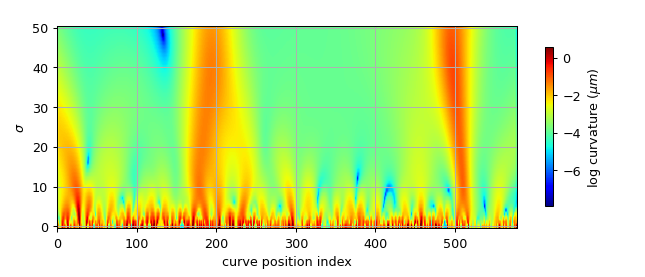

In [21]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
pl = ax.imshow(np.log(res["curvature"]),cmap="jet",vmax=np.percentile(res["curvature"],99));
ax.invert_yaxis();
ax.set_aspect(5);
ax.grid();
ax.set_xlabel("curve position index")
ax.set_ylabel(r"$\sigma$")
cb = fig.colorbar(pl,shrink=0.7)
cb.set_label("log curvature $(\mu m)$")
plt.tight_layout();

What we see is many "flows" that are red at small $\sigma$ (high curvatures) then the magnitude is decreased at higher $\sigma$ (smaller curvature). Some cases decrease quickly while the others stay much longer. The study of scale space can be applied in different contexts as shown below.

### Main turns

Main turns are positions on the curve where it mainly change its orientation. We combine different criteria to filter out the main turns including curvature scale space and angle threshold. 

In [22]:
sigmas = range(51)
main_turns_ids = denoised_curve.main_turns(sigmas)

The return is the indices of main turns:

In [23]:
main_turns_ids

array([ 40,  60, 103, 194, 241, 268, 320, 390, 430, 510, 562, 625, 723,
       820])

Let's plot them:

<IPython.core.display.Javascript object>


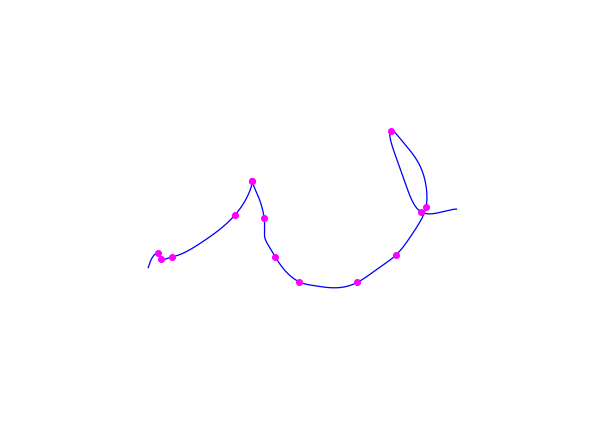

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
denoised_curve.plot(ax,show_root=False);
ax.scatter(denoised_curve.coors[main_turns_ids,0],
           denoised_curve.coors[main_turns_ids,1],
           denoised_curve.coors[main_turns_ids,2],
           c="magenta",depthshade=False);
ax.axis('off');
plt.tight_layout();

The resulted main turns depend on some parameters. Please read the function docs for more detail. For example, the returned main turns would be reduced by increasing `ridgelength_thr` (default is set as 0.1).

In [25]:
sigmas = range(51)
main_turns_ids = denoised_curve.main_turns(sigmas, ridgelength_thr=0.5)
print(main_turns_ids)

fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
denoised_curve.plot(ax,show_root=False);
ax.scatter(denoised_curve.coors[main_turns_ids,0],
           denoised_curve.coors[main_turns_ids,1],
           denoised_curve.coors[main_turns_ids,2],
           c="magenta",depthshade=False);
ax.axis('off');
plt.tight_layout();

[ 40 103 268 390 430 510 625 723 820]


<IPython.core.display.Javascript object>

We recommend to run the jupyter notebook of this page for better 3D view of the main turns.

### Dimension decomposition

This section describes a decomposition of curve into segments corresponding to different intrinsic dimensions such as 3D, 2D and 1D. Estimating intrinsic dimensionality is often associated with a scale (level of detail) of the curve. We provide `decompose_intrinsicdim(sig_c,delta_sig)` in class `Curve` to compute the decomposition at the scale `sig_c +- delta_sig`.

In [26]:
dim_result = denoised_curve.decompose_intrinsicdim(sig_c=100,delta_sig=5)

The returns are indices of planar and linear segments (the 3D segments are the rest).

In [27]:
dim_result

{'planeline_pred': [[35, 137], [420, 575]], 'line_pred': [[55, 135]]}

Let's plot the result:

<IPython.core.display.Javascript object>


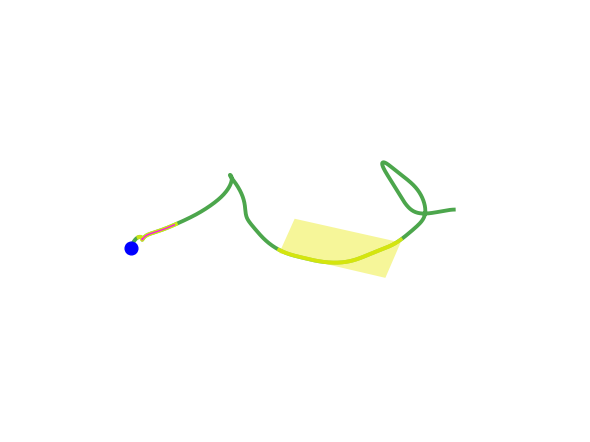

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
denoised_curve.plot_intrinsicdim(ax,overrided_curve=denoised_curve)
ax.axis('off');
plt.tight_layout();

Here, the green segments correspond to 3D, the yellow ones are the planar segments and the red ones are linear segments.

### Local 3D scale

Another application of intrinsic dimension decomposition is to produce a local 3D scale map that indicate the scale (here we define scale as radius of curvature) at which the point change from 3D to 2D/1D. The script below compute the local 3D scale of curve from a list of radius of curvature.

In [29]:
sigmas = np.arange(0,205,5)
local_scale = denoised_curve.compute_local_3d_scale_sigma(sigmas)

and plot it:

<IPython.core.display.Javascript object>


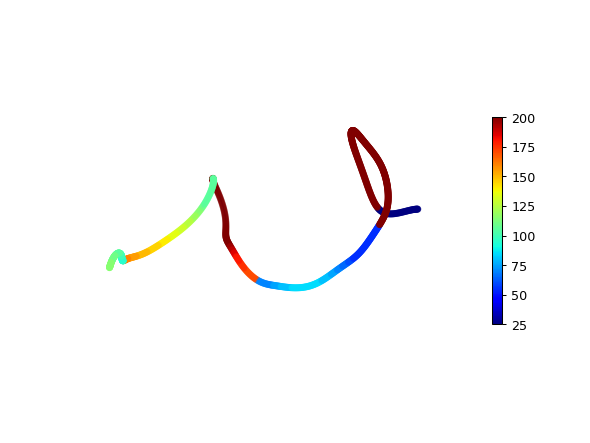

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
_, point_pl, _ = denoised_curve.plot(ax,show_root=False,point_args={"c":local_scale,"cmap":"jet"})
fig.colorbar(point_pl,shrink=0.5);
ax.axis('off');
plt.tight_layout();

## Aligment

We propose a simple alignment of a target curve to a reference curve by root shifting and baseline rotation. Let's first import a second curve from another neuronal tree:

number of points on curve: 553


<IPython.core.display.Javascript object>


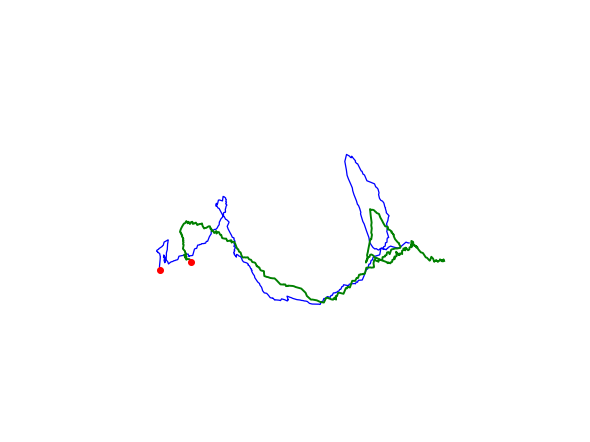

In [31]:
# reading neuron
filename = "data/FT_T_dG-1.swc"
neuron = trees.Tree.from_swc(filename)

# extracting spine
spine_nodes = neuron.compute_spine() # getting spine nodes
spine_coors = neuron.get_coordinates(spine_nodes).values # getting their coordinates

# creating curve from the spine coordinates
curve2 = curves.Curve(spine_coors) 

print("number of points on curve:",len(curve2.coors))

fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
curve.plot(ax);
curve2.plot(ax,line_args={"c":"g"});
ax.axis('off');
plt.tight_layout();

We now align the green curve (target) to the blue curve (reference):

In [32]:
curve2_aligned = curves.align(curve2,curve)

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
# plot curves
curve.plot(ax);
curve2_aligned.plot(ax,line_args={"c":"g"});
# plot baseline
ax.plot(curve2_aligned.coors[[0,-1],0],curve2_aligned.coors[[0,-1],1],curve2_aligned.coors[[0,-1],2],c="m",linestyle="dashed")
ax.axis('off');
plt.tight_layout();

<IPython.core.display.Javascript object>

The green curve is now root shifted and rotated to the baseline in magenta (i.e. line between two endpoints). The alignment can be useful to compare the difference in shape between two curves.